In [1]:
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.source.event import Event
from sigvisa.signals.common import Waveform

import cPickle as pickle

In [2]:
with open('/home/dmoore/python/sigvisa/logs/mcmc/01862/step_000149/pickle.sg', 'rb') as f:
    sg = pickle.load(f)

In [3]:
from sigvisa.infer.template_xc import *

In [4]:
eid_src = 5
eid_target=4
sta="MK31"
phase="P"
band="freq_0.8_4.5"
chan="BHZ"

tmnodes = sg.get_template_nodes(eid_src, sta, phase, band, chan)
wn_src = [n for n in tmnodes['coda_height'][1].children if isinstance(n, ObservedSignalNode)][0]

tmnodes = sg.get_template_nodes(eid_target, sta, phase, band, chan)
wn_target = [n for n in tmnodes['coda_height'][1].children if isinstance(n, ObservedSignalNode)][0]
current_atime = tmnodes['arrival_time'][1].get_value()



In [5]:
# current move:
# loads a short period of the source event and a long period of the target event.
#    - this is counterintuitive but has to do with 
# slides the xcs to get a proposal distribution for their relative arrival times (or peak time if you prefer)

# currently src and target do not match up. 
# I need to slide the source signal 1.5s to the left on the graph. 
# If I make the source atime *earlier*, this will actually push the bumps *later* on the graph
# so I need to make source atime *later* to fix the problem?

In [6]:
signal_src, atime_src, idx_src = get_arrival_signal(sg, eid_src, phase, wn_src,
                                                    pre_s=0.0, post_s=10.0,
                                                    pred_atime=False)
print atime_src

1241407393.7


In [7]:
signal_target, atime_target, idx_target = get_arrival_signal(sg, eid_target, phase, wn_target,
                                                             pre_s=15.0, post_s=25.0,
                                                             pred_atime=False)
print atime_target
# goal: ...392.0

1240933314.53


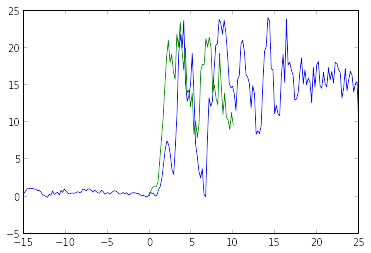

In [8]:
x_src = np.linspace(0, 10.0, len(signal_src))
x_target = np.linspace(-15.0, 25.0, len(signal_target))
plot(x_target, signal_target/2.0)
plot(x_src, signal_src)

102


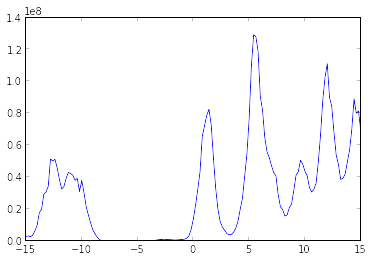

In [9]:
xc = fastxc(signal_src, signal_target)
temp=20.0
xcdist = np.exp(temp*xc)

x = np.linspace(-15.0, 15.0, len(xc))
#plot(x, xc)
plot(x, xcdist)
print np.argmax(xcdist)

81


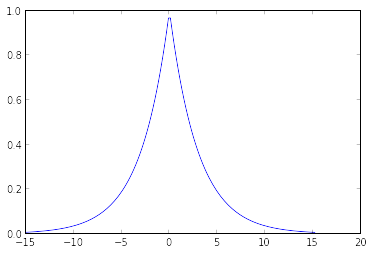

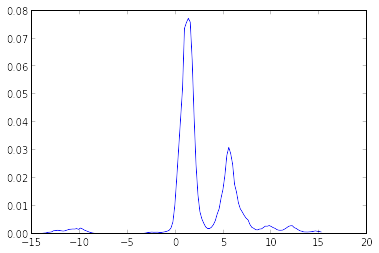

In [10]:
srate = wn_target.srate

target_window_soffset = -15.0 + idx_target/srate
target_window_eoffset = target_window_soffset + len(xc)/srate
x = np.linspace(target_window_soffset, target_window_eoffset, len(xc))
prior = np.exp(-np.abs(x/3.0))
xcdist *= prior
xcdist /= np.sum(xcdist)

plot(x, prior)
figure()
plot(x, xcdist)
print np.argmax(xcdist)

In [11]:
def idx_to_atime(idx):
    # if src signal was clipped, this will give us the
    # *correct* target index at which the arrival should
    # start
    st_idx = idx-idx_src

    # atime_target + target_window_soffset gives the
    # time of the beginning of the window.
    # then we add st_idx/srate to get to the arrival time.
    atime = atime_target + target_window_soffset + st_idx/srate
    return atime

def atime_to_idx(atime):
    # st_idx gives the index into the target window for this atime
    st_idx = int(np.round(srate*(atime - atime_target - target_window_soffset)))
    
    # now we correct to get the index we'd expect the source window
    # to align at, given that it might be clipped
    return st_idx+idx_src

proposed_idx = np.random.choice(np.arange(len(xcdist)), p=xcdist)
print proposed_idx
print idx_to_atime(proposed_idx) - current_atime
print atime_to_idx(idx_to_atime(proposed_idx))

print atime_to_idx(current_atime)

82
1.40000009537
82
75


In [12]:
print atime_target
print current_atime # current atime is 10s after the predicted atime?

1240933314.53
1240933314.53


In [13]:



#try:
#except:
# pass

proposed_idx = 79 #np.random.choice(np.arange(len(xcdist)), p=xcdist)
proposed_atime = idx_to_atime(proposed_idx)
print proposed_atime

log_qforward = np.log(xcdist[proposed_idx])
backwards_idx = atime_to_idx(current_atime)
log_qbackward = np.log(xcdist[backwards_idx])

print log_qforward
print log_qbackward

1240933315.33
-2.60871352412
-3.90736974506


In [14]:

print wn_target.upwards_message_normalizer()
print sg.current_log_p()

-5444.46548084
-99228.9545474


In [15]:
tmnodes = sg.get_template_nodes(eid_target, sta, phase, band, chan)
wn_target = [n for n in tmnodes['coda_height'][1].children if isinstance(n, ObservedSignalNode)][0]
tmnodes['arrival_time'][1].set_value(proposed_atime)




In [16]:
k_offset, n_offset = tmnodes['peak_offset']
current_offset = n_offset.get_value(key=k_offset)
peak = current_atime + np.exp(current_offset)

proposed_offset = np.log(peak - proposed_atime)
print current_offset
print proposed_offset

n_offset.set_value(proposed_offset)

1.84010920343
1.70424360134


In [17]:
print wn_target.upwards_message_normalizer()
print sg.current_log_p()

-5457.06504049
-99300.9919806


reading station detections... 


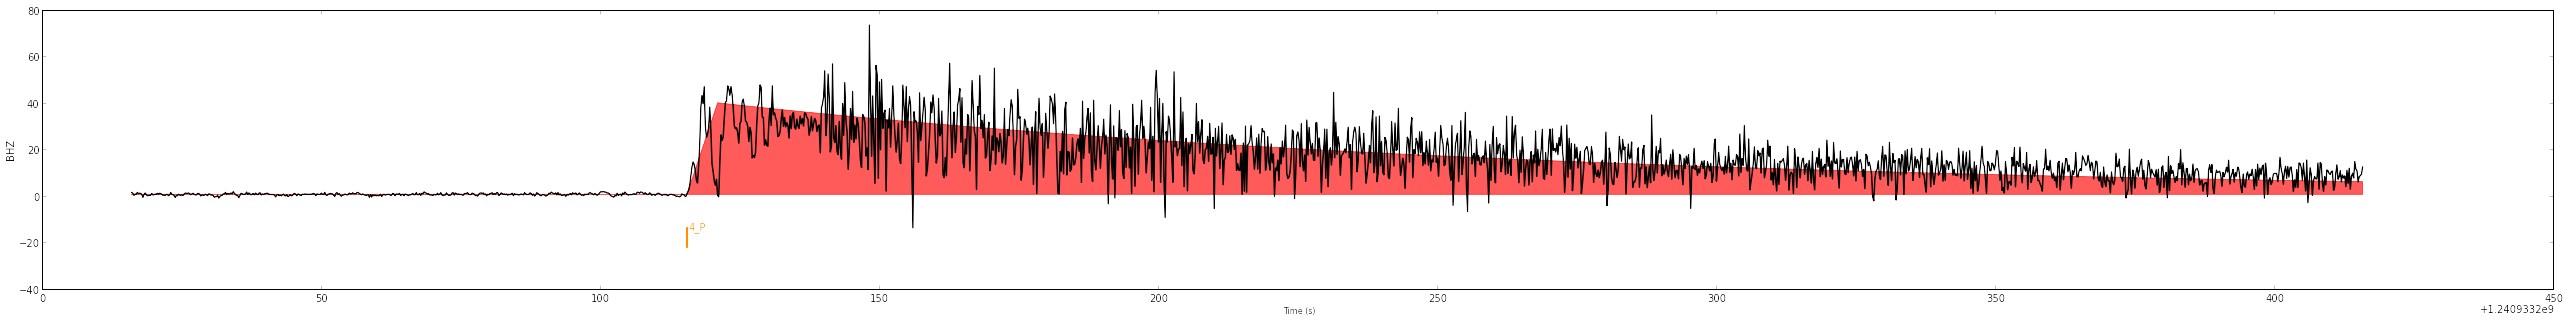

In [18]:
from sigvisa.plotting.plot import plot_with_fit_shapes, plot_pred_atimes

def do_plot(wn, ax=None):
    if ax is None:
        f = plt.figure(figsize=(45,5))
        ax=f.add_subplot(111)
    shape_colors = plot_with_fit_shapes(fname=None, wn=wn, axes=ax, plot_wave=True, 
                                        plot_pred=True, model_lw=None, ev_lw=None)
    atimes = dict([("%d_%s" % (eid, phase), wn.get_template_params_for_arrival(eid=eid, phase=phase)[0]['arrival_time']) for (eid, phase) in wn.arrivals()])
    colors = dict([("%d_%s" % (eid, phase), shape_colors[eid]) for (eid, phase) in wn.arrivals()])
    plot_pred_atimes(dict(atimes), wn.get_wave(), axes=ax, color=colors, alpha=1.0, bottom_rel=-0.1, top_rel=0.0)
    return ax
do_plot(wn_target)